In [2]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import initialise as init

In [77]:
rtt_lga = init.gpd.read_file('australian_lgas_with_rtt.geojson')
rtt_lga['lga_code'] = rtt_lga['lga_code'].astype(int)
rtt_lga.drop(['year', 'ste_code', 'lga_name', 'lga_area_code', 'lga_type', 'lga_name_long'], axis=1, inplace=True)
print('The columns in the rtt_lga dataframe are:')
print(rtt_lga.columns)

The columns in the rtt_lga dataframe are:
Index(['ste_name', 'lga_code', 'RA fid', '5th Percentile', '10th Percentile',
       '25th Percentile', '50th Percentile', '75th Percentile',
       '90th Percentile', '95th Percentile', '95th:5th Ratio', 'Sample Size',
       'Busy 5th Percentile', 'Busy 10th Percentile', 'Busy 25th Percentile',
       'Busy 50th Percentile', 'Busy 75th Percentile', 'Busy 90th Percentile',
       'Busy 95th Percentile', 'Busy 95th:5th Ratio', 'Busy Sample Size',
       '5th Percentile Change', '10th Percentile Change',
       '25th Percentile Change', '50th Percentile Change',
       '75th Percentile Change', '90th Percentile Change',
       '95th Percentile Change', '95th:5th Ratio Change', 'geometry'],
      dtype='object')


In [78]:
major_pop_centres = [
    ['Melbourne', 'Victoria', -37.810272, 144.962646],
    ['Sydney', 'New South Wales', -33.865143, 151.209900],
    ['Brisbane', 'Queensland', -27.470125, 153.021072],
    ['Perth', 'Western Australia',-31.953512, 115.857048],
    ['Adelaide', 'South Australia', -34.921230, 138.599503],
    ['Gold Coast', 'Queensland', -28.016666, 153.399994],
    ['Newcastle', 'New South Wales', -32.916668, 151.750000],
    ['Canberra', 'Australian Capital Territory', -35.282001, 149.128998],
    ['Sunshine Coast', 'Queensland', -26.650000, 153.066666],
    ['Central Coast', 'New South Wales', -33.425018, 151.342224],
    ['Wollongong', 'New South Wales', -34.425072, 150.893143],
    ['Geelong', 'Victoria', -38.150002, 144.350006],
    ['Hobart', 'Tasmania', -42.880554, 147.324997],
    ['Townsville', 'Queensland', -19.258965, 146.816956],
    ['Cairns', 'Queensland', -16.925491, 145.754120],
    ['Toowoomba', 'Queensland', -27.566668, 151.949997],
    ['Darwin', 'Northern Territory', -12.462827, 130.841782],
    ['Ballarat', 'Victoria', -37.549999, 143.850006],
    ['Bendigo', 'Victoria', -36.757786, 144.278702],
    ['Albury-Wodonga', 'New South Wales', -36.080780, 146.916473],
]


capital_cities = [
    ['Melbourne', 'Victoria', -37.810272, 144.962646],
    ['Sydney', 'New South Wales', -33.865143, 151.209900],
    ['Brisbane', 'Queensland', -27.470125, 153.021072],
    ['Perth', 'Western Australia', -31.953512, 115.857048],
    ['Adelaide', 'South Australia', -34.921230, 138.599503],
    ['Canberra', 'Australia Capital Territory', -35.282001, 149.128998],
    ['Hobart', 'Tasmania', -42.880554, 147.324997],
    ['Darwin', 'Northern Territory', -12.462827, 130.841782],
]

rtt_lga['Centroid'] = rtt_lga.geometry.centroid
rtt_lga['major_city_distance'] = None
rtt_lga['closest_capital_distance'] = None
rtt_lga['own_capital_distance'] = None

C:\Users\43472\AppData\Local\Temp\ipykernel_6956\105059650.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rtt_lga['Centroid'] = rtt_lga.geometry.centroid


In [79]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle
from shapely.geometry import Point

# Extract LGA centroid coordinates
lga_coords = np.array([(centroid.y, centroid.x) for centroid in rtt_lga['Centroid']])  # (lat, lon)

# Function to calculate nearest city distance
def nearest_city_distance(lga_point, cities):
    distances = [great_circle(lga_point, (city[2], city[3])).kilometers for city in cities]
    return min(distances), cities[np.argmin(distances)]  # Return min distance and city info

# Calculate nearest distances for major population centers
rtt_lga['major_city_distance'] = rtt_lga['Centroid'].apply(lambda x: nearest_city_distance((x.y, x.x), major_pop_centres)[0])
rtt_lga['closest_major_city'] = rtt_lga['Centroid'].apply(lambda x: nearest_city_distance((x.y, x.x), major_pop_centres)[1][0])  # Get city name

# Calculate nearest distances for capital cities
rtt_lga['closest_capital_distance'] = rtt_lga['Centroid'].apply(lambda x: nearest_city_distance((x.y, x.x), capital_cities)[0])
rtt_lga['closest_capital_city'] = rtt_lga['Centroid'].apply(lambda x: nearest_city_distance((x.y, x.x), capital_cities)[1][0])  # Get city name

# Calculate own capital distance based on the state of the LGA
def own_capital_distance(row):
    state = row['ste_name']
    # Find the capital city for the given state
    capital = next((city for city in capital_cities if city[1] == state), None)
    if capital: 
        return great_circle((row['Centroid'].y, row['Centroid'].x), (capital[2], capital[3])).kilometers
    return None

# Apply the function to calculate own capital distance
rtt_lga['own_capital_distance'] = rtt_lga.apply(own_capital_distance, axis=1)

## Spatial Join by LGA codes

In [99]:
# read in the data
data = init.pd.read_csv('SE Indexes Sem 2.csv')
print('The columns in the SEIFA dataframe are:')
print(data.columns)
print()
print('The columns in the spatial joined dataframe are:')
merged_data = data.merge(rtt_lga, on='lga_code', how='inner')
print(merged_data.columns)

The columns in the SEIFA dataframe are:
Index(['lga_code', 'IRSD Decile', 'IRSAD Decile', 'IER Decile', 'IEO Decile',
       'Median Income', 'Lowest Quartile Income %',
       'Highest Quartile Income %', 'Gini Coefficient', 'Area (Km^2)',
       'Population', 'Population Density', 'Population Change',
       'Population Change %', 'Indigenous Population',
       'Indigenous Population %'],
      dtype='object')

The columns in the spatial joined dataframe are:
Index(['lga_code', 'IRSD Decile', 'IRSAD Decile', 'IER Decile', 'IEO Decile',
       'Median Income', 'Lowest Quartile Income %',
       'Highest Quartile Income %', 'Gini Coefficient', 'Area (Km^2)',
       'Population', 'Population Density', 'Population Change',
       'Population Change %', 'Indigenous Population',
       'Indigenous Population %', 'ste_name', 'RA fid', '5th Percentile',
       '10th Percentile', '25th Percentile', '50th Percentile',
       '75th Percentile', '90th Percentile', '95th Percentile',
       '95t

In [100]:
# indexes for each level of remoteness
mc_index = [ 0,  7, 13, 20, 27, 34, 45]
ir_index = [ 1,  8, 14, 21, 28, 35, 46]
or_index = [ 2,  9, 15, 22, 29, 36, 40]
r_index =  [ 3, 10, 16, 23, 30, 37, 41]
vr_index = [ 4, 17, 24, 31, 42]
indexes_list = [mc_index, ir_index, or_index, r_index, vr_index]

In [101]:
merged_data['Major City'] = 0
merged_data['Inner Regional'] = 0
merged_data['Outer Regional'] = 0
merged_data['Remote'] = 0
merged_data['Very Remote'] = 0

for i, indexes in enumerate(merged_data['RA fid']):
    if indexes in mc_index:
        merged_data['Major City'][i] = 1
    elif indexes in ir_index:
        merged_data['Inner Regional'][i] = 1
    elif indexes in or_index:
        merged_data['Outer Regional'][i] = 1
    elif indexes in r_index:
        merged_data['Remote'][i] = 1
    elif indexes in vr_index:
        merged_data['Very Remote'][i] = 1
    else:
        print('Error: index not found')

C:\Users\43472\AppData\Local\Temp\ipykernel_6956\672249249.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['Inner Regional'][i] = 1
C:\Users\43472\AppData\Local\Temp\ipykernel_6956\672249249.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['Outer Regional'][i] = 1
C:\Users\43472\AppData\Local\Temp\ipykernel_6956\672249249.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['Remote'][i] = 1


In [103]:
merged_data.loc[:, 'IRSD Decile']               = merged_data['IRSD Decile'].astype(float)
merged_data.loc[:, 'IRSAD']                     = merged_data['IRSAD Decile'].astype(float)
merged_data.loc[:, 'IER Decile']                = merged_data['IER Decile'].astype(float)
merged_data.loc[:, 'IEO Decile']                = merged_data['IEO Decile'].astype(float)
merged_data.loc[:, 'Median Income']             = merged_data['Median Income'].astype(float)
merged_data.loc[:, 'Lowest Quartile Income %']  = merged_data['Lowest Quartile Income %'].astype(float)
merged_data.loc[:, 'Highest Quartile Income %'] = merged_data['Highest Quartile Income %'].astype(float)
merged_data.loc[:, 'Gini Coefficient']          = merged_data['Gini Coefficient'].astype(float)
merged_data.loc[:, 'Area (Km^2)']               = merged_data['Area (Km^2)'].astype(float)
merged_data.loc[:, 'Population']                = merged_data['Population'].astype(float)
merged_data.loc[:, 'Population Density']        = merged_data['Population Density'].astype(float)
merged_data.loc[:, 'Population Change']         = merged_data['Population Change'].astype(float)
merged_data.loc[:, 'Population Change %']       = merged_data['Population Change %'].astype(float)
merged_data.loc[:, 'Indigenous Population']     = merged_data['Indigenous Population'].astype(float)
merged_data.loc[:, 'Indigenous Population %']   = merged_data['Indigenous Population %'].astype(float)

In [90]:
#political = init.gpd.read_file('LGA_to_Electorate.geojson')
#political = political.drop(['geometry'], axis=1)
#political.to_csv('LGA_to_Electorate.csv', index=False)

In [96]:
electorate_to_lga = init.pd.read_csv('LGA_to_Electorate.csv')
print(electorate_to_lga.columns)
electorate_info = init.pd.read_csv('Electorate_Info.csv')
print(electorate_info.columns)

Index(['Division', 'Sortname', 'lga_code', 'lga_name', 'ste_name'], dtype='object')
Index(['Division', 'Previous Party', 'Previous Seat Status',
       'Successful Party', 'Current Seat Status', 'Swing', 'Seat Change',
       'is Safe', 'is Fairly Safe', 'is Marginal', 'Remained Marginal'],
      dtype='object')


In [104]:
# Merge the DataFrames on the "electorate" column
merged_electorate_lga = pd.merge(electorate_to_lga, electorate_info, on='Division', how='left')
#merged_electorate_lga.to_csv('LGA_to_Electorate_Info.csv', index=False)

In [116]:
if 'geometry' in merged_data.columns:
    merged_data.drop(['geometry'], axis=1, inplace=True)
final_merge = pd.merge(merged_data, merged_electorate_lga, on='lga_code', how='left')
print(final_merge.columns)

Index(['lga_code', 'IRSD Decile', 'IRSAD Decile', 'IER Decile', 'IEO Decile',
       'Median Income', 'Lowest Quartile Income %',
       'Highest Quartile Income %', 'Gini Coefficient', 'Area (Km^2)',
       'Population', 'Population Density', 'Population Change',
       'Population Change %', 'Indigenous Population',
       'Indigenous Population %', 'ste_name_x', 'RA fid', '5th Percentile',
       '10th Percentile', '25th Percentile', '50th Percentile',
       '75th Percentile', '90th Percentile', '95th Percentile',
       '95th:5th Ratio', 'Sample Size', 'Busy 5th Percentile',
       'Busy 10th Percentile', 'Busy 25th Percentile', 'Busy 50th Percentile',
       'Busy 75th Percentile', 'Busy 90th Percentile', 'Busy 95th Percentile',
       'Busy 95th:5th Ratio', 'Busy Sample Size', '5th Percentile Change',
       '10th Percentile Change', '25th Percentile Change',
       '50th Percentile Change', '75th Percentile Change',
       '90th Percentile Change', '95th Percentile Change',
   

In [117]:
final_merge = final_merge.drop(['ste_name_x', 'RA fid', '10th Percentile', 
                                '25th Percentile', '75th Percentile', '90th Percentile', 
        'Sample Size', 'Busy 5th Percentile',
       'Busy 10th Percentile', 'Busy 25th Percentile', 'Busy 50th Percentile',
       'Busy 75th Percentile', 'Busy 90th Percentile', 'Busy 95th Percentile',
       'Busy 95th:5th Ratio', 'Busy Sample Size', '5th Percentile Change',
       '10th Percentile Change', '25th Percentile Change',
       '50th Percentile Change', '75th Percentile Change',
       '90th Percentile Change', '95th Percentile Change',
       '95th:5th Ratio Change', 'Centroid', 'closest_major_city', 'closest_capital_city',
       'IRSAD', 'Sortname', 'lga_name', 'ste_name_y'], axis = 1)

In [118]:
print(final_merge.columns)

Index(['lga_code', 'IRSD Decile', 'IRSAD Decile', 'IER Decile', 'IEO Decile',
       'Median Income', 'Lowest Quartile Income %',
       'Highest Quartile Income %', 'Gini Coefficient', 'Area (Km^2)',
       'Population', 'Population Density', 'Population Change',
       'Population Change %', 'Indigenous Population',
       'Indigenous Population %', '5th Percentile', '50th Percentile',
       '95th Percentile', '95th:5th Ratio', 'major_city_distance',
       'closest_capital_distance', 'own_capital_distance', 'Major City',
       'Inner Regional', 'Outer Regional', 'Remote', 'Very Remote', 'Division',
       'Previous Party', 'Previous Seat Status', 'Successful Party',
       'Current Seat Status', 'Swing', 'Seat Change', 'is Safe',
       'is Fairly Safe', 'is Marginal', 'Remained Marginal'],
      dtype='object')


In [119]:
final_merge.to_csv('SEIFA_RTT_LGA.csv', index=False)

For the variable: 5th Percentile

                            OLS Regression Results                            
Dep. Variable:         5th Percentile   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     5.863
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           7.13e-06
Time:                        15:50:04   Log-Likelihood:                -2197.6
No. Observations:                 403   AIC:                             4409.
Df Residuals:                     396   BIC:                             4437.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

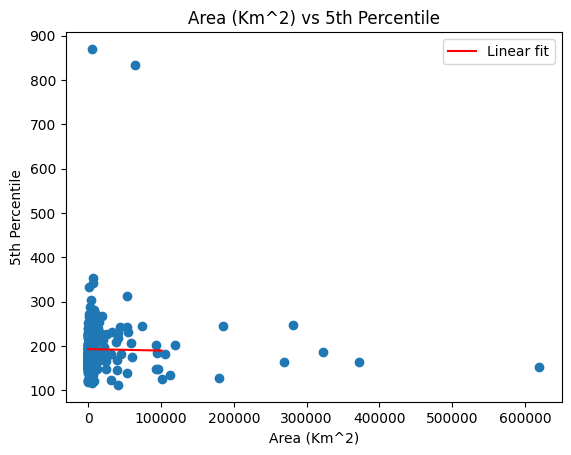

In [6]:
import statsmodels.api as sm

#merged_data['RA fid'] = merged_data['RA fid'].astype(int)
#chosen_index = vr_index
#selected_region = [merged_data.iloc[i] for i in range(len(merged_data['RA fid'])) if int(merged_data.iloc[i]['RA fid']) in chosen_index]
#selected_region = init.pd.DataFrame(selected_region)

selected_region = merged_data

# Make sure the data is cleaned
# test variables excluding remoteness
test_variables = ['Gini Coefficient', '% Population Change', 'Area (Km^2)', 'Population Density', 'Indigenous Population', '% Indigenous Population']

# test variables including remoteness
#test_variables = ['IRSD Decile', 'IRSAD Decile', 'IER Decile', 'IEO Decile', 'Population', 'Gini Coefficient', 'Population Change', '% Population Change', 'Area (Km^2)', 'Population Density', 'Indigenous Population', '% Indigenous Population', 'Inner Regional', 'Outer Regional', 'Remote', 'Very Remote']
test_df = selected_region[test_variables]

# Convert to float
#test_df.loc[:, 'IRSD Decile']               = test_df['IRSD Decile'].astype(float)
#test_df.loc[:, 'IRSAD Decile']              = test_df['IRSAD Decile'].astype(float)
#test_df.loc[:, 'IER Decile']                = test_df['IER Decile'].astype(float)
#test_df.loc[:, 'IEO Decile']                = test_df['IEO Decile'].astype(float)
#test_df.loc[:, 'Population']                = test_df['Population'].astype(float)
test_df.loc[:, 'Gini Coefficient']          = test_df['Gini Coefficient'].astype(float)
#test_df.loc[:, 'Population Change']         = test_df['Population Change'].astype(float)
test_df.loc[:, '% Population Change']       = test_df['% Population Change'].astype(float)
test_df.loc[:, 'Area (Km^2)']               = test_df['Area (Km^2)'].astype(float)
test_df.loc[:, 'Population Density']        = test_df['Population Density'].astype(float)
test_df.loc[:, 'Indigenous Population']     = test_df['Indigenous Population'].astype(float)
test_df.loc[:, '% Indigenous Population']   = test_df['% Indigenous Population'].astype(float)
#test_df.loc[:, 'Inner Regional']            = test_df['Inner Regional'].astype(int)
#test_df.loc[:, 'Outer Regional']            = test_df['Outer Regional'].astype(int)
#test_df.loc[:, 'Remote']                    = test_df['Remote'].astype(int)
#test_df.loc[:, 'Very Remote']               = test_df['Very Remote'].astype(int)

x = test_df.dropna()
variable_tested = "5th Percentile"
y = merged_data[variable_tested].astype(float)
y = y.loc[x.index]  # Ensure y matches the remaining rows in x
y = y.dropna()
x = x.loc[y.index]  # Ensure x matches the remaining rows in y

# Add a constant to the independent value
x = sm.add_constant(x)

# Fit the model
model = sm.OLS(y, x).fit()

# Print the summary
print('For the variable:', variable_tested)
print()
print(model.summary())

# ROBUST VARIABLE TESTING
sig_var = 'Area (Km^2)'
#init.plt.title(f'{y} vs {vars[sig_var]} with Linear Fit')
init.plt.scatter(x[sig_var], y)
#init.plt.xlabel("Gini Coefficient")
#init.plt.ylabel("95th:5th Ratio")

single_x = x[sig_var]

y = y.loc[single_x.index]  # Ensure y matches the remaining rows in x
y = y.dropna()
single_x = single_x.loc[y.index]  # Ensure x matches the remaining rows in y

# TRIM THE TOP AND BOTTOM 5
single_x = single_x.sort_values()
y = y.loc[x.index]

trim = 10
single_x = single_x.iloc[trim:-trim]
y = y.iloc[trim:-trim]

# Fit a linear model
coefficients = init.np.polyfit(single_x, y, 1)  # 1 specifies a linear fit
linear_fit = init.np.poly1d(coefficients)

# Generate x values for the fit line
x_fit = init.np.linspace(single_x.min(), single_x.max(), 100)
y_fit = linear_fit(x_fit)

# Plot the linear fit
init.plt.plot(x_fit, y_fit, color='red', label='Linear fit')

# Add labels and a legend
init.plt.xlabel(sig_var)
init.plt.ylabel(variable_tested)
init.plt.title(f"{sig_var} vs {variable_tested}")
init.plt.legend()

# Show plot
init.plt.show()

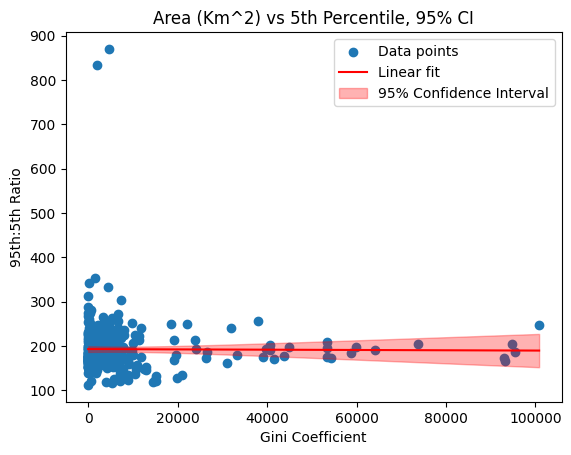

In [7]:
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# Scatter plot
init.plt.scatter(single_x, y, label='Data points')

single_x = init.np.array(single_x)
y = init.np.array(y)

# Reshape x for LinearRegression
x_reshape = single_x.reshape(-1, 1)
model = LinearRegression().fit(x_reshape, y)
y_pred = model.predict(x_reshape)

# Calculate residuals and standard error
residuals = y - y_pred
standard_error = init.np.sqrt(init.np.sum(residuals**2) / (len(x) - 2))
X_with_intercept = init.np.hstack([init.np.ones_like(x_reshape), x_reshape])
design_matrix = X_with_intercept
cov_matrix = init.np.linalg.inv(init.np.dot(design_matrix.T, design_matrix)) * standard_error**2

# Calculate prediction intervals
x_fit = init.np.linspace(single_x.min(), single_x.max(), 100).reshape(-1, 1)
y_fit = model.predict(x_fit)

# Calculate the standard error of predictions
X_fit_with_intercept = init.np.hstack([init.np.ones_like(x_fit), x_fit])
predicted_var = init.np.sum(init.np.dot(X_fit_with_intercept, cov_matrix) * X_fit_with_intercept, axis=1)
confidence_interval = 1.96 * init.np.sqrt(predicted_var)  # 95% confidence interval

# Plot the linear fit
init.plt.plot(x_fit, y_fit, color='red', label='Linear fit')

# Plot the confidence interval
init.plt.fill_between(x_fit.flatten(), y_fit - confidence_interval, y_fit + confidence_interval, color='red', alpha=0.3, label='95% Confidence Interval')

# Add labels and a legend
init.plt.xlabel('Gini Coefficient')
init.plt.ylabel('95th:5th Ratio')
init.plt.title(f"{sig_var} vs {variable_tested}, 95% CI")
init.plt.legend()

# Show plot
init.plt.show()


In [8]:
# Compute Pearson correlation coefficients
pearson_corr = x[test_variables].corr()

# Print Pearson correlation coefficients
print("Pearson correlation coefficients:")
print(pearson_corr)
print()


Pearson correlation coefficients:
                         Gini Coefficient  % Population Change  Area (Km^2)  \
Gini Coefficient                 1.000000            -0.286977    -0.037205   
% Population Change             -0.286977             1.000000    -0.205054   
Area (Km^2)                     -0.037205            -0.205054     1.000000   
Population Density               0.148977            -0.046883    -0.128912   
Indigenous Population           -0.323568             0.253704     0.018929   
% Indigenous Population         -0.094923            -0.195438     0.481416   

                         Population Density  Indigenous Population  \
Gini Coefficient                   0.148977              -0.323568   
% Population Change               -0.046883               0.253704   
Area (Km^2)                       -0.128912               0.018929   
Population Density                 1.000000              -0.084877   
Indigenous Population             -0.084877               1.00

In [11]:
urban_data = merged_data[merged_data['RA fid'].isin(mc_index) | merged_data['RA fid'].isin(ir_index)]
rural_data = merged_data[merged_data['RA fid'].isin(or_index) | merged_data['RA fid'].isin(r_index) | merged_data['RA fid'].isin(vr_index)]
print(len(merged_data) - len(urban_data) - len(rural_data))
print('Urban:', len(urban_data))
print('Rural:', len(rural_data))

0
Urban: 234
Rural: 310


In [2]:
ruralavgs = [1.960, 1.668, 2.570, 2.293, 1.485, 2.820, 1.230, 3.430, 2.497, 2.607, 2.950, 
            1.687, 1.276, 2.447, 3.270, 2.960, 2.337, 3.053, 2.485, 3.543, 3.277, 1.860,
            3.333, 3.030, 1.915]
urbanavgs = [1.823333333, 2.9325, 3.573333333, 2.126666667, 1.226666667, 2.106666667, 2.1]
ruralstdves = [0.941, 0.826, 1.071, 1.070, 0.106, 0.632, 0.300, 0.325,
               0.261, 0.883, 0.622, 0.604, 1.276, 0.181, 0.583, 0.468,
               0.735, 0.509, 0.894, 0.110, 0.291, 0.368, 0.483, 0.679, 1.294]
urbanstdevs = [0.617764788, 0.3365016097, 0.47648015, 0.3178574104,
               0.4123509832, 0.5076416059]

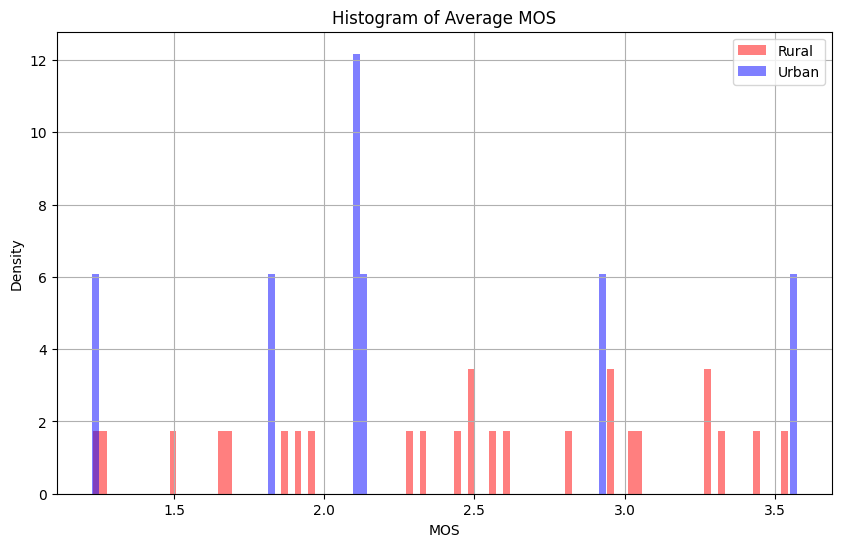

In [3]:
import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(10, 6))

# Plot histogram for rural averages
plt.hist(ruralavgs, bins=100, alpha=0.5, color='red', label='Rural', density=True)

# Plot histogram for urban averages
plt.hist(urbanavgs, bins=100, alpha=0.5, color='blue', label='Urban', density=True)

# Add labels and title
plt.title("Histogram of Average MOS")
plt.xlabel("MOS")
plt.ylabel("Density")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

0 non-numeric values turned to NaN in urban data
0 non-numeric values turned to NaN in rural data


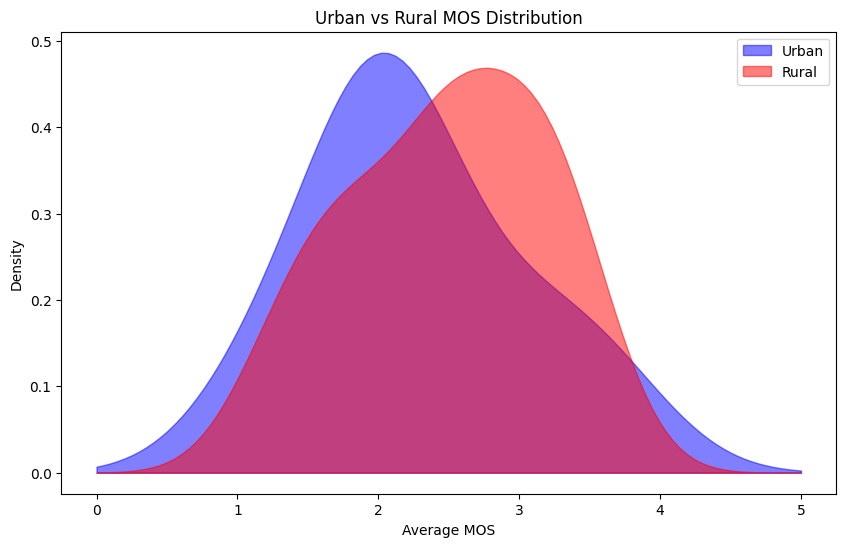

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Convert the lists to numpy arrays and drop NaN values (if any)
column1 = np.array(urbanavgs, dtype=np.float64)
column2 = np.array(ruralavgs, dtype=np.float64)

# Check for NaN values
print(np.isnan(column1).sum(), "non-numeric values turned to NaN in urban data")
print(np.isnan(column2).sum(), "non-numeric values turned to NaN in rural data")

# Drop NaN values
column1 = column1[~np.isnan(column1)]
column2 = column2[~np.isnan(column2)]

# Calculate KDE for both columns
kde1 = gaussian_kde(column1)
kde2 = gaussian_kde(column2)

# Create a range of x values for plotting
#x_range = np.linspace(min(min(column1), min(column2)), max(max(column1), max(column2)), 200)
x_range = np.linspace(0, 5, 100)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot KDE for urban data (blue)
plt.fill_between(x_range, kde1(x_range), alpha=0.5, color='blue', label='Urban')

# Plot KDE for rural data (red)
plt.fill_between(x_range, kde2(x_range), alpha=0.5, color='red', label='Rural')

# Add labels and legend
plt.ylabel('Density')
plt.xlabel('Average MOS')  # Assuming this is still relevant
plt.title('Urban vs Rural MOS Distribution')
plt.legend()

# Display the plot
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

variable = '95th:5th Ratio'
# Convert the column to numeric, coercing errors to NaN
urban_data[variable] = init.pd.to_numeric(urban_data[variable], errors='coerce')
rural_data[variable] = init.pd.to_numeric(rural_data[variable], errors='coerce')

# Check for any NaN values created by the coercion
print(urban_data[variable].isnull().sum(), "non-numeric values turned to NaN")
print(rural_data[variable].isnull().sum(), "non-numeric values turned to NaN")

# Select the column of data to plot
column1 = urban_data[variable].dropna().to_numpy()
column2 = rural_data[variable].dropna().to_numpy()


# Calculate KDE for both columns
kde1 = gaussian_kde(column1)
kde2 = gaussian_kde(column2)

# Create a range of x values for plotting
x_range = np.linspace(min(min(column1), min(column2)), max(max(column1), max(column2)), 200)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot KDE for urban data (blue)
plt.fill_between(x_range, kde1(x_range), alpha=0.5, color='blue', label='Urban')

# Plot KDE for rural data (red)
plt.fill_between(x_range, kde2(x_range), alpha=0.5, color='red', label='Rural')

# Add labels and legend
#plt.xlabel(f"{variable}")
plt.ylabel('Density')
#plt.title(f"Urban vs Rural {variable}")
plt.legend()

# Display the plot
plt.show()

0    0
dtype: int64 non-numeric values turned to NaN
0    0
dtype: int64 non-numeric values turned to NaN


ValueError: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

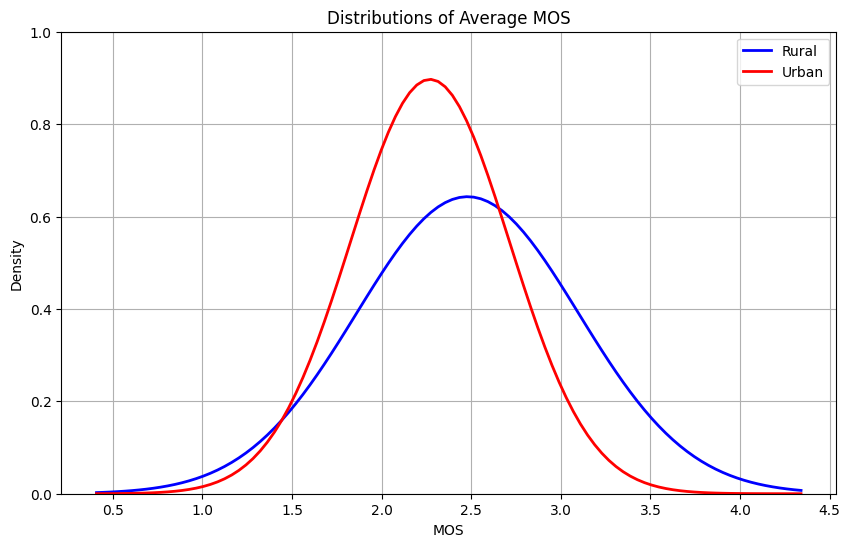

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Sample data: Replace these with your actual data

# Calculate means and standard deviations
mean_1 = np.mean(ruralavgs)
sd_1 = np.mean(ruralstdves)
mean_2 = np.mean(urbanavgs)
sd_2 = np.mean(urbanstdevs)

# Generate a sequence of x values
x_values = np.linspace(min(mean_1, mean_2) - 3 * max(sd_1, sd_2),
                       max(mean_1, mean_2) + 3 * max(sd_1, sd_2),
                       num=100)

# Compute the y values for both distributions
y_values_1 = norm.pdf(x_values, loc=mean_1, scale=sd_1)
y_values_2 = norm.pdf(x_values, loc=mean_2, scale=sd_2)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the first normal distribution
plt.plot(x_values, y_values_1, linewidth=2, color='blue', label='Rural')

# Add the second normal distribution to the same plot
plt.plot(x_values, y_values_2, linewidth=2, color='red', label='Urban')

# Add labels and title
plt.title("Distributions of Average MOS")
plt.xlabel("MOS")
plt.ylabel("Density")
plt.ylim(0, 1)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
